## In this discussion, we will build a basic hybrid CNN-LSTM model for classification on the EEG dataset

#### This notebook has been created by Tonmoy.

## (i) Importing the necessary packages

In [6]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

In [7]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [8]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# URGENT: new train/valid, test data 
person_X_test_sub0_idx = list(np.where(person_test == 0)[0])
X_test = X_test[person_X_test_sub0_idx]
print(X_test.shape)

person_X_train_valid_sub0_idx = list(np.where(person_train_valid == 0)[0])
X_train_valid = X_train_valid[person_X_train_valid_sub0_idx]
print(X_train_valid.shape)

person_y_test_sub0_idx = list(np.where(person_test == 0)[0])
y_test = y_test[person_y_test_sub0_idx]
print(y_test.shape)

person_y_train_valid_sub0_idx = list(np.where(person_train_valid == 0)[0])
y_train_valid = y_train_valid[person_y_train_valid_sub0_idx]
print(y_train_valid.shape)

#------------------------------------------------


## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

# 2115/375 ~= 0.177, 237 * 0.177 ~= 42
ind_valid = np.random.choice(237, 42, replace=False)
ind_train = np.array(list(set(range(237)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)




(50, 22, 1000)
(237, 22, 1000)
(50,)
(237,)
Shape of X after trimming: (195, 22, 500)
Shape of X after maxpooling: (195, 22, 250)
Shape of X after averaging+noise and concatenating: (390, 22, 250)
Shape of X after subsampling and concatenating: (780, 22, 250)
Shape of X after trimming: (42, 22, 500)
Shape of X after maxpooling: (42, 22, 250)
Shape of X after averaging+noise and concatenating: (84, 22, 250)
Shape of X after subsampling and concatenating: (168, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of training set: (780, 22, 250)
Shape of validation set: (168, 22, 250)
Shape of training labels: (780,)
Shape of validation labels: (168,)
Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)
Shape of training labels after categorical conversion: (780, 4)
Shape of validation labels after c

## (iii)(CNN-LSTM) Defining the architecture of the hybrid CNN-LSTM model

In [11]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((350))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((350,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(35, dropout=0.6, recurrent_dropout=0.1, input_shape=(350,1), return_sequences=False))

# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()







2023-03-17 17:33:54.345494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        2775      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         6300      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

## (iv)(CNN-LSTM) Defining the hyperparameters of the hybrid CNN-LSTM model

In [9]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## (v)(CNN-LSTM) Compiling, training and validating the model

In [12]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/50
13/13 [==============================] - 9s 323ms/step - loss: 1.3884 - accuracy: 0.2397 - val_loss: 1.3918 - val_accuracy: 0.1131
Epoch 2/50
13/13 [==============================] - 3s 267ms/step - loss: 1.3771 - accuracy: 0.3256 - val_loss: 1.4031 - val_accuracy: 0.2857
Epoch 3/50
13/13 [==============================] - 4s 277ms/step - loss: 1.3472 - accuracy: 0.3026 - val_loss: 1.4444 - val_accuracy: 0.2857
Epoch 4/50
13/13 [==============================] - 4s 270ms/step - loss: 1.2521 - accuracy: 0.4154 - val_loss: 1.5844 - val_accuracy: 0.2857
Epoch 5/50
13/13 [==============================] - 4s 276ms/step - loss: 1.1307 - accuracy: 0.4564 - val_loss: 1.9219 - val_accuracy: 0.2857
Epoch 6/50
13/13 [==============================] - 4s 280ms/step - loss: 1.0656 - accuracy: 0.4654 - val_loss: 2.0864 - val_accuracy: 0.2857
Epoch 7/50
13/13 [==============================] - 4s 300ms/step - loss: 1.0081 - accuracy: 0.4885 - val_loss: 1.8803 - val_accuracy: 0.3155
Epoch 

## (vi)(CNN-LSTM) Visualizing the accuracy and loss trajectory

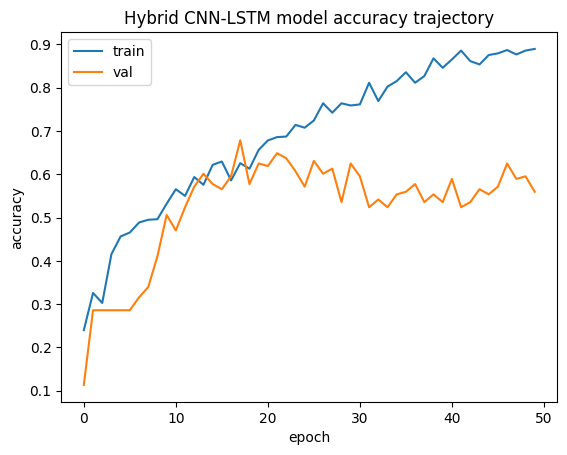

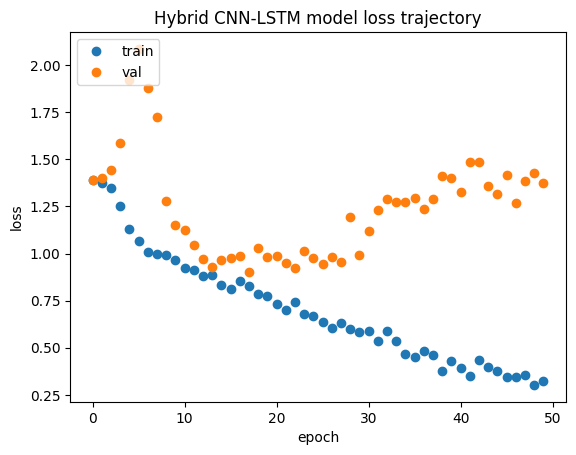

In [13]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN-LSTM) Testing the performance of the hybrid CNN-LSTM model on the held out test set

In [14]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.574999988079071
